# Imports

In [1]:
import pandas as pd
import numpy as np
from mapnet import MAPNet, config

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

def weighted_mean_absolute_percentage_error(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    if true.ndim == 1:
        true = true.reshape(1,true.shape[0])
        pred = pred.reshape(1,pred.shape[0])
    wmape = np.abs(pred-true).sum(axis=1) / np.abs(true).sum(axis=1) * 100
    return wmape

def RRMSE(true, pred):
    return np.sqrt(mean_squared_error(true.T,pred.T,multioutput='raw_values'))/np.sqrt(np.sum(true**2, axis=1))*100

# Set the number of CPU cores

In [2]:
config(jobs=10)

# Synthetize spectra

In [3]:
net = MAPNet(line="5208")
# phase, teff, logg, mh, incl, alpha, beta, gamma, y2, y3, m, vsini, vmic
x = np.array([0.17, 7157, 4.12, -1.6, 33, -11, 78, 3, 0.1, 0.1, 1300, 3.4, 0.5])

spectrum = net.synthetize_spectra(x)
print(spectrum.shape)

No GPU detected, using CPU.
(1, 4, 96)


## Plot spectra

C:\Users\elgua\AppData\Local\Temp\ipykernel_5052\280640483.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\elgua\AppData\Local\Temp\ipykernel_5052\280640483.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\elgua\AppData\Local\Temp\ipykernel_5052\280640483.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\elgua\AppData\Local\Temp\ipykernel_5052\280640483.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with 

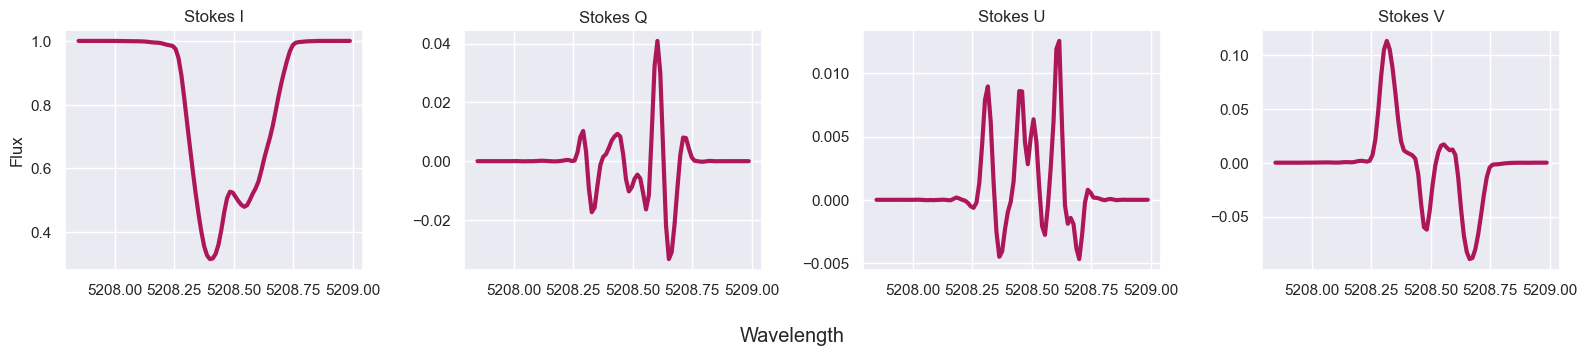

In [4]:
sns.set(rc={"figure.figsize": (16, 4)})
fig, axes = plt.subplots(1, 4, sharex=True)
stokes_labels = ['I', 'Q', 'U', 'V']
wl = net.get_wavelength()
for j, ax in enumerate(axes):
    sns.lineplot(x=wl, y=spectrum[0,j,:], lw=3, ax=ax, color=sns.palettes.color_palette('rocket')[2])

    ax.set_title(f'Stokes {stokes_labels[j]}')
    ax.set_xlabel('')
    if j == 0:
        ax.set_ylabel('Flux')
    ax.legend().remove()
fig.supxlabel('Wavelength')

plt.tight_layout()
plt.subplots_adjust(top=0.8, bottom=0.2)  
plt.show()

# Inversion with multiple phases

In [11]:
x = np.array([[0.05, 7157, 4.12, -1.7, 33, -11, 78, 3, 0.15, 0.05, 1550, 3.4, 1.2],
             [0.20, 7157, 4.12, -1.7, 33, -11, 78, 3, 0.15, 0.05, 1550, 3.4, 1.2],
             [0.35, 7157, 4.12, -1.7, 33, -11, 78, 3, 0.15, 0.05, 1550, 3.4, 1.2],
             [0.50, 7157, 4.12, -1.7, 33, -11, 78, 3, 0.15, 0.05, 1550, 3.4, 1.2],
             [0.65, 7157, 4.12, -1.7, 33, -11, 78, 3, 0.15, 0.05, 1550, 3.4, 1.2],
             [0.80, 7157, 4.12, -1.7, 33, -11, 78, 3, 0.15, 0.05, 1550, 3.4, 1.2],
             [0.95, 7157, 4.12, -1.7, 33, -11, 78, 3, 0.15, 0.05, 1550, 3.4, 1.2]])

phases = list(x[:,0])
spectrum_phases = net.synthetize_spectra(x)

In [12]:
solution, inv_spectra, fitness = net.inversion(spectrum_phases, n_particles=1024, iters=50, verbose=1, phases=phases)

----- Start PSO -----
----------------------------
Iteration: 1   Best Fitness: 0.00043088166
----------------------------
Iteration: 2   Best Fitness: 0.00039727348
----------------------------
Iteration: 3   Best Fitness: 0.00032098492
----------------------------
Iteration: 4   Best Fitness: 0.00026438996
----------------------------
Iteration: 5   Best Fitness: 0.00022809906
----------------------------
Iteration: 6   Best Fitness: 0.00016964883
----------------------------
Iteration: 7   Best Fitness: 0.00013839666
----------------------------
Iteration: 8   Best Fitness: 0.00013839666
----------------------------
Iteration: 9   Best Fitness: 0.00013817365
----------------------------
Iteration: 10   Best Fitness: 0.00013563139
----------------------------
Iteration: 11   Best Fitness: 0.000130596
----------------------------
Iteration: 12   Best Fitness: 0.00012089882
----------------------------
Iteration: 13   Best Fitness: 0.00011659833
----------------------------
Iteration: 

## Plot inversion

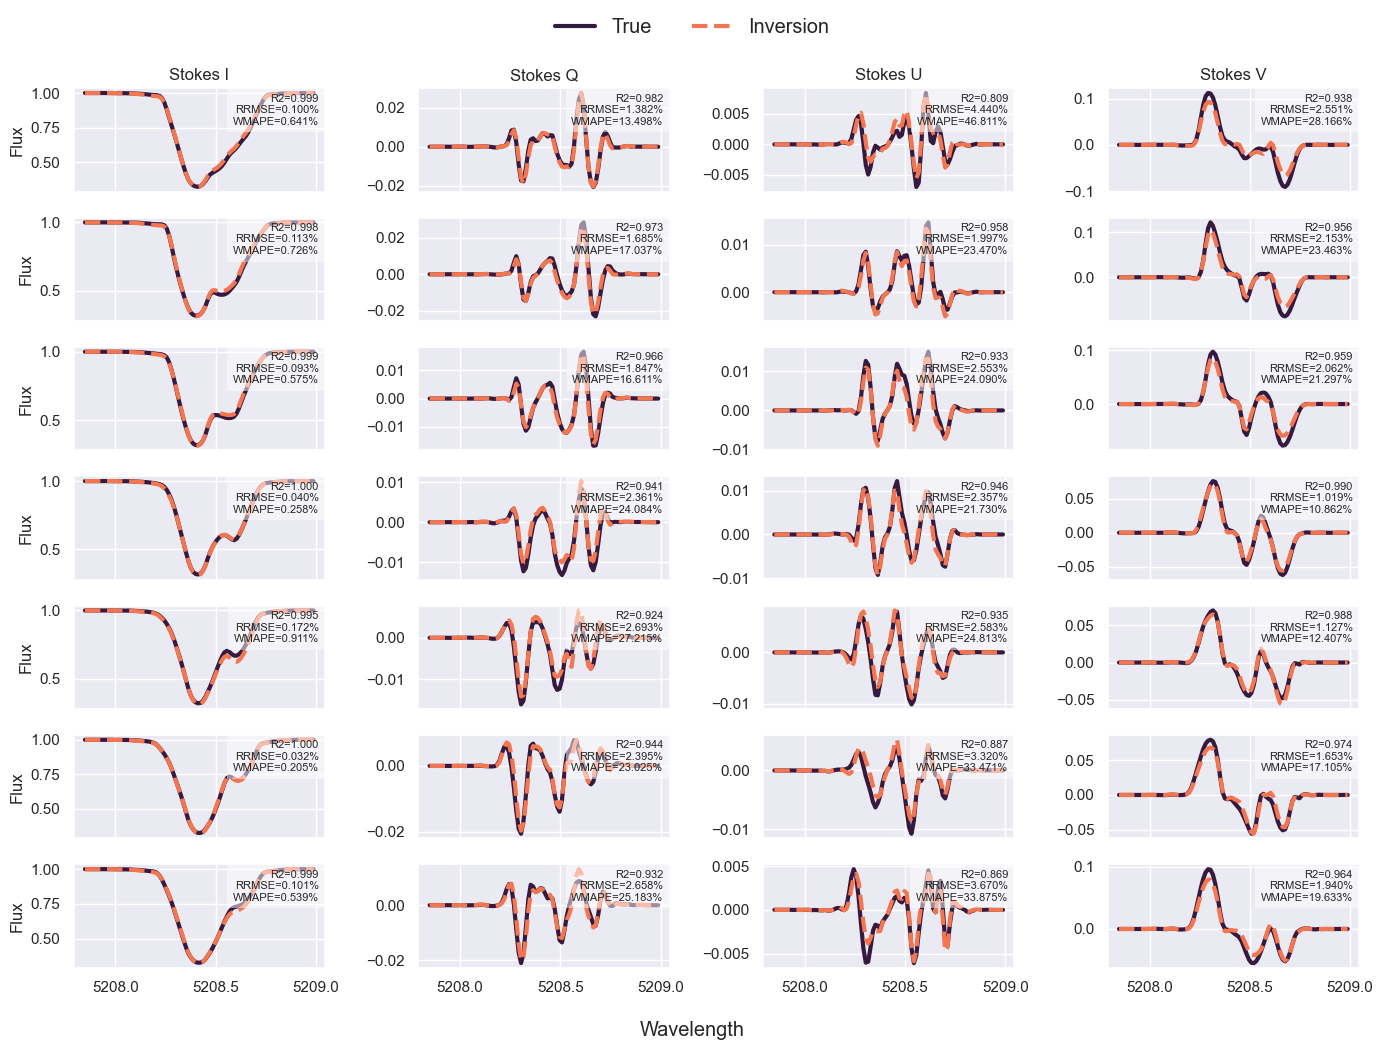

In [18]:
sns.set(rc={"figure.figsize": (14, 10)})
fig, axes = plt.subplots(7, 4, sharex=True)
stokes_labels = ['I', 'Q', 'U', 'V']
wl = net.get_wavelength()
for i in range(7):
    for j in range(4):
        ax = axes[i, j]
        sns.lineplot(x=wl, y=spectrum_phases[i,j,:], lw=3, ax=ax, color=sns.palettes.color_palette('rocket')[0], label='True')
        line_true = ax.lines[-1]
        sns.lineplot(x=wl, y=inv_spectra[i,j,:], lw=3, linestyle='--', ax=ax, color=sns.palettes.color_palette('rocket')[4], label='Inversion')
        line_pred = ax.lines[-1]
        if i == 0:
            ax.set_title(f'Stokes {stokes_labels[j]}')
        ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel('Flux')
            legend_lines = [line_true, line_pred]
        ax.legend().remove()
        ax.text(0.975, 0.95, 
                f'R2={r2_score(spectrum_phases[i,j,:], inv_spectra[i,j,:]):.3f}\nRRMSE={RRMSE(spectrum_phases[i,j,:].reshape(1, 96), inv_spectra[i,j,:].reshape(1, 96))[0]:.3f}%\nWMAPE={weighted_mean_absolute_percentage_error(spectrum_phases[i,j,:], inv_spectra[i,j,:])[0]:.3f}%', 
                transform=ax.transAxes, 
                ha='right', va='top', 
                fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
fig.supxlabel('Wavelength')
fig.legend(legend_lines, ['True', 'Inversion'], loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05), fontsize='large')
plt.tight_layout()
plt.show()

# Inversion with fixed parameters

In [19]:
solution, inv_spectra, fitness = net.inversion(spectrum_phases, n_particles=1024, iters=50, verbose=1, phases=phases, fixed_teff=7150, fixed_logg=4.1)

----- Start PSO -----
----------------------------
Iteration: 1   Best Fitness: 0.00039336184
----------------------------
Iteration: 2   Best Fitness: 0.00020299538
----------------------------
Iteration: 3   Best Fitness: 0.00015021759
----------------------------
Iteration: 4   Best Fitness: 0.00013684147
----------------------------
Iteration: 5   Best Fitness: 0.00013039212
----------------------------
Iteration: 6   Best Fitness: 0.00012701005
----------------------------
Iteration: 7   Best Fitness: 0.000121857775
----------------------------
Iteration: 8   Best Fitness: 9.5697396e-05
----------------------------
Iteration: 9   Best Fitness: 8.528293e-05
----------------------------
Iteration: 10   Best Fitness: 7.713975e-05
----------------------------
Iteration: 11   Best Fitness: 5.6492638e-05
----------------------------
Iteration: 12   Best Fitness: 3.8895912e-05
----------------------------
Iteration: 13   Best Fitness: 2.3624405e-05
----------------------------
Iteration:

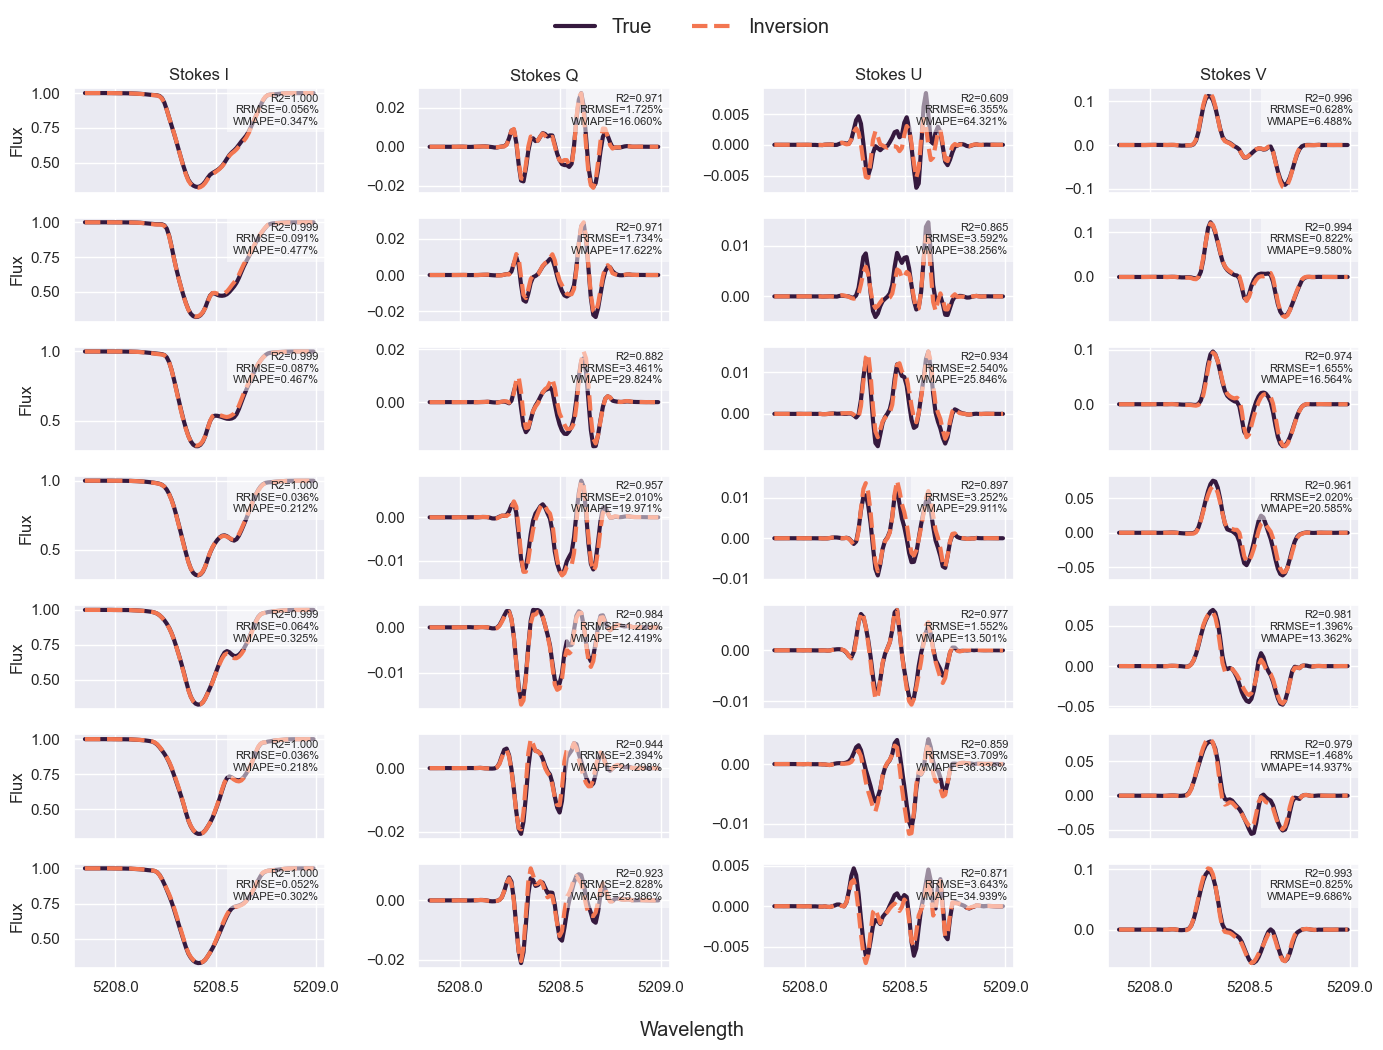

In [20]:
sns.set(rc={"figure.figsize": (14, 10)})
fig, axes = plt.subplots(7, 4, sharex=True)
stokes_labels = ['I', 'Q', 'U', 'V']
wl = net.get_wavelength()
for i in range(7):
    for j in range(4):
        ax = axes[i, j]
        sns.lineplot(x=wl, y=spectrum_phases[i,j,:], lw=3, ax=ax, color=sns.palettes.color_palette('rocket')[0], label='True')
        line_true = ax.lines[-1]
        sns.lineplot(x=wl, y=inv_spectra[i,j,:], lw=3, linestyle='--', ax=ax, color=sns.palettes.color_palette('rocket')[4], label='Inversion')
        line_pred = ax.lines[-1]
        if i == 0:
            ax.set_title(f'Stokes {stokes_labels[j]}')
        ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel('Flux')
            legend_lines = [line_true, line_pred]
        ax.legend().remove()
        ax.text(0.975, 0.95, 
                f'R2={r2_score(spectrum_phases[i,j,:], inv_spectra[i,j,:]):.3f}\nRRMSE={RRMSE(spectrum_phases[i,j,:].reshape(1, 96), inv_spectra[i,j,:].reshape(1, 96))[0]:.3f}%\nWMAPE={weighted_mean_absolute_percentage_error(spectrum_phases[i,j,:], inv_spectra[i,j,:])[0]:.3f}%', 
                transform=ax.transAxes, 
                ha='right', va='top', 
                fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
fig.supxlabel('Wavelength')
fig.legend(legend_lines, ['True', 'Inversion'], loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05), fontsize='large')
plt.tight_layout()
plt.show()

# Inversion with range in params

In [21]:
solution, inv_spectra, fitness = net.inversion(spectrum_phases, n_particles=1024, iters=50, verbose=1, phases=phases, teff_range=(7100,7200), m_range=(1300,1700))

----- Start PSO -----
----------------------------
Iteration: 1   Best Fitness: 0.00053381856
----------------------------
Iteration: 2   Best Fitness: 0.00047993238
----------------------------
Iteration: 3   Best Fitness: 0.0004445858
----------------------------
Iteration: 4   Best Fitness: 0.0003782445
----------------------------
Iteration: 5   Best Fitness: 0.0003468888
----------------------------
Iteration: 6   Best Fitness: 0.00026383833
----------------------------
Iteration: 7   Best Fitness: 0.00025503593
----------------------------
Iteration: 8   Best Fitness: 0.00024878496
----------------------------
Iteration: 9   Best Fitness: 0.00024588514
----------------------------
Iteration: 10   Best Fitness: 0.00024257702
----------------------------
Iteration: 11   Best Fitness: 0.00024257702
----------------------------
Iteration: 12   Best Fitness: 0.0002399573
----------------------------
Iteration: 13   Best Fitness: 0.00023076433
----------------------------
Iteration: 14

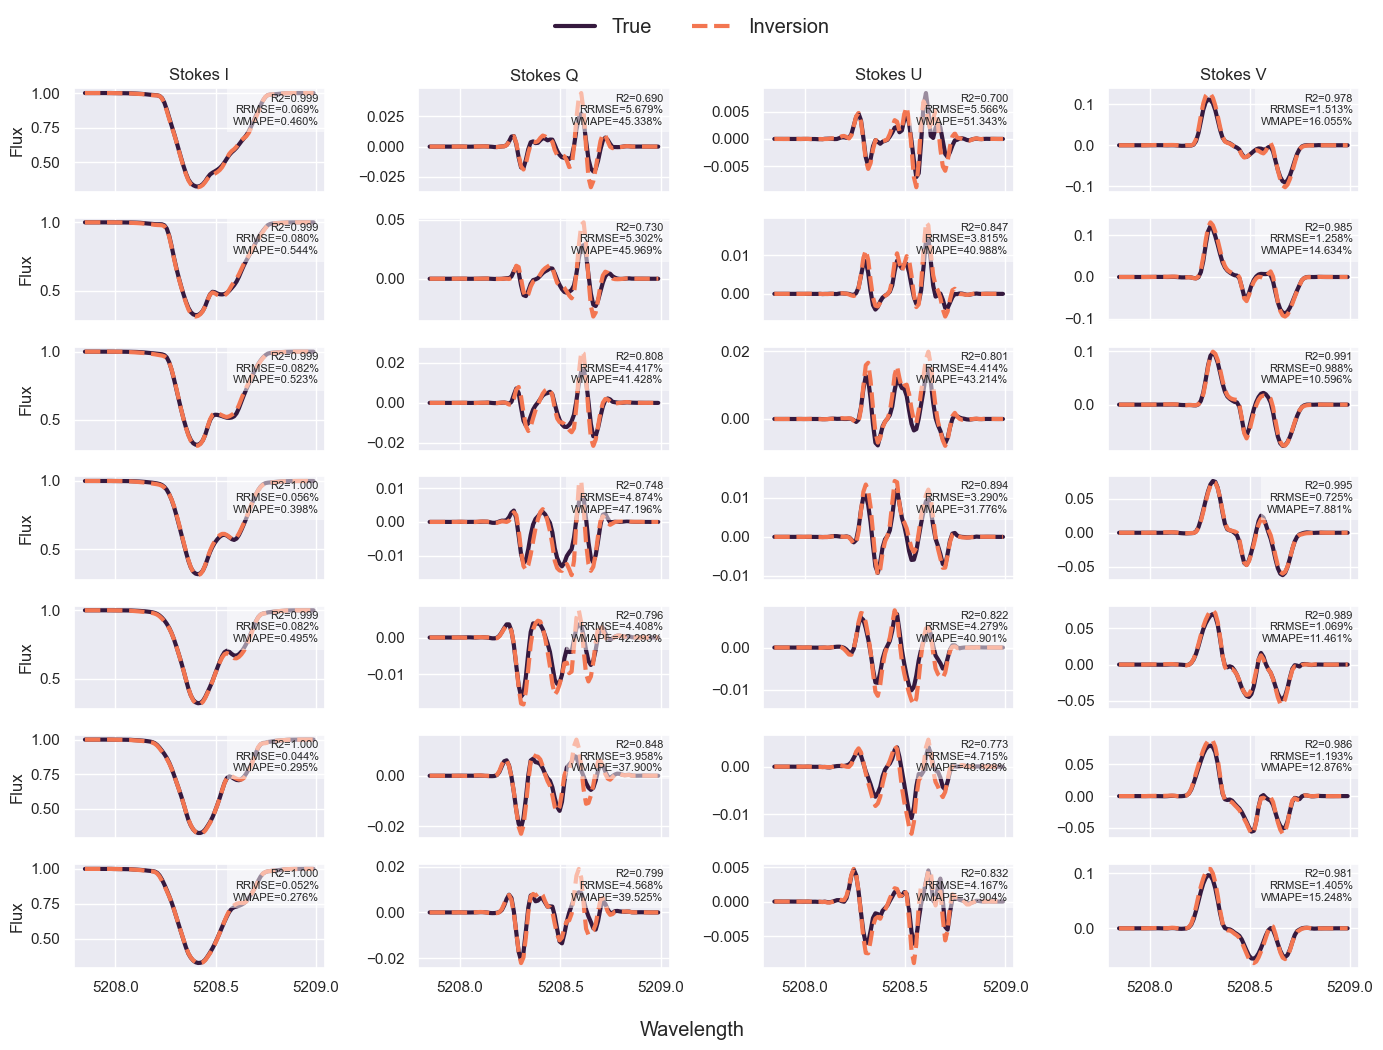

In [22]:
sns.set(rc={"figure.figsize": (14, 10)})
fig, axes = plt.subplots(7, 4, sharex=True)
stokes_labels = ['I', 'Q', 'U', 'V']
wl = net.get_wavelength()
for i in range(7):
    for j in range(4):
        ax = axes[i, j]
        sns.lineplot(x=wl, y=spectrum_phases[i,j,:], lw=3, ax=ax, color=sns.palettes.color_palette('rocket')[0], label='True')
        line_true = ax.lines[-1]
        sns.lineplot(x=wl, y=inv_spectra[i,j,:], lw=3, linestyle='--', ax=ax, color=sns.palettes.color_palette('rocket')[4], label='Inversion')
        line_pred = ax.lines[-1]
        if i == 0:
            ax.set_title(f'Stokes {stokes_labels[j]}')
        ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel('Flux')
            legend_lines = [line_true, line_pred]
        ax.legend().remove()
        ax.text(0.975, 0.95, 
                f'R2={r2_score(spectrum_phases[i,j,:], inv_spectra[i,j,:]):.3f}\nRRMSE={RRMSE(spectrum_phases[i,j,:].reshape(1, 96), inv_spectra[i,j,:].reshape(1, 96))[0]:.3f}%\nWMAPE={weighted_mean_absolute_percentage_error(spectrum_phases[i,j,:], inv_spectra[i,j,:])[0]:.3f}%', 
                transform=ax.transAxes, 
                ha='right', va='top', 
                fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
fig.supxlabel('Wavelength')
fig.legend(legend_lines, ['True', 'Inversion'], loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05), fontsize='large')
plt.tight_layout()
plt.show()

# Select which Stokes to use in inversion

In [23]:
solution, inv_spectra, fitness = net.inversion(spectrum_phases, n_particles=1024, iters=50, verbose=1, phases=phases, use_Stokes_I=True, use_Stokes_Q=False, use_Stokes_U=False, use_Stokes_V=True)

----- Start PSO -----
----------------------------
Iteration: 1   Best Fitness: 0.001292116
----------------------------
Iteration: 2   Best Fitness: 0.0011078108
----------------------------
Iteration: 3   Best Fitness: 0.0006649811
----------------------------
Iteration: 4   Best Fitness: 0.00062346796
----------------------------
Iteration: 5   Best Fitness: 0.0005820247
----------------------------
Iteration: 6   Best Fitness: 0.000568639
----------------------------
Iteration: 7   Best Fitness: 0.00054220756
----------------------------
Iteration: 8   Best Fitness: 0.0005373495
----------------------------
Iteration: 9   Best Fitness: 0.0004983955
----------------------------
Iteration: 10   Best Fitness: 0.0004983955
----------------------------
Iteration: 11   Best Fitness: 0.00048747106
----------------------------
Iteration: 12   Best Fitness: 0.00047752686
----------------------------
Iteration: 13   Best Fitness: 0.00047752686
----------------------------
Iteration: 14   Bes

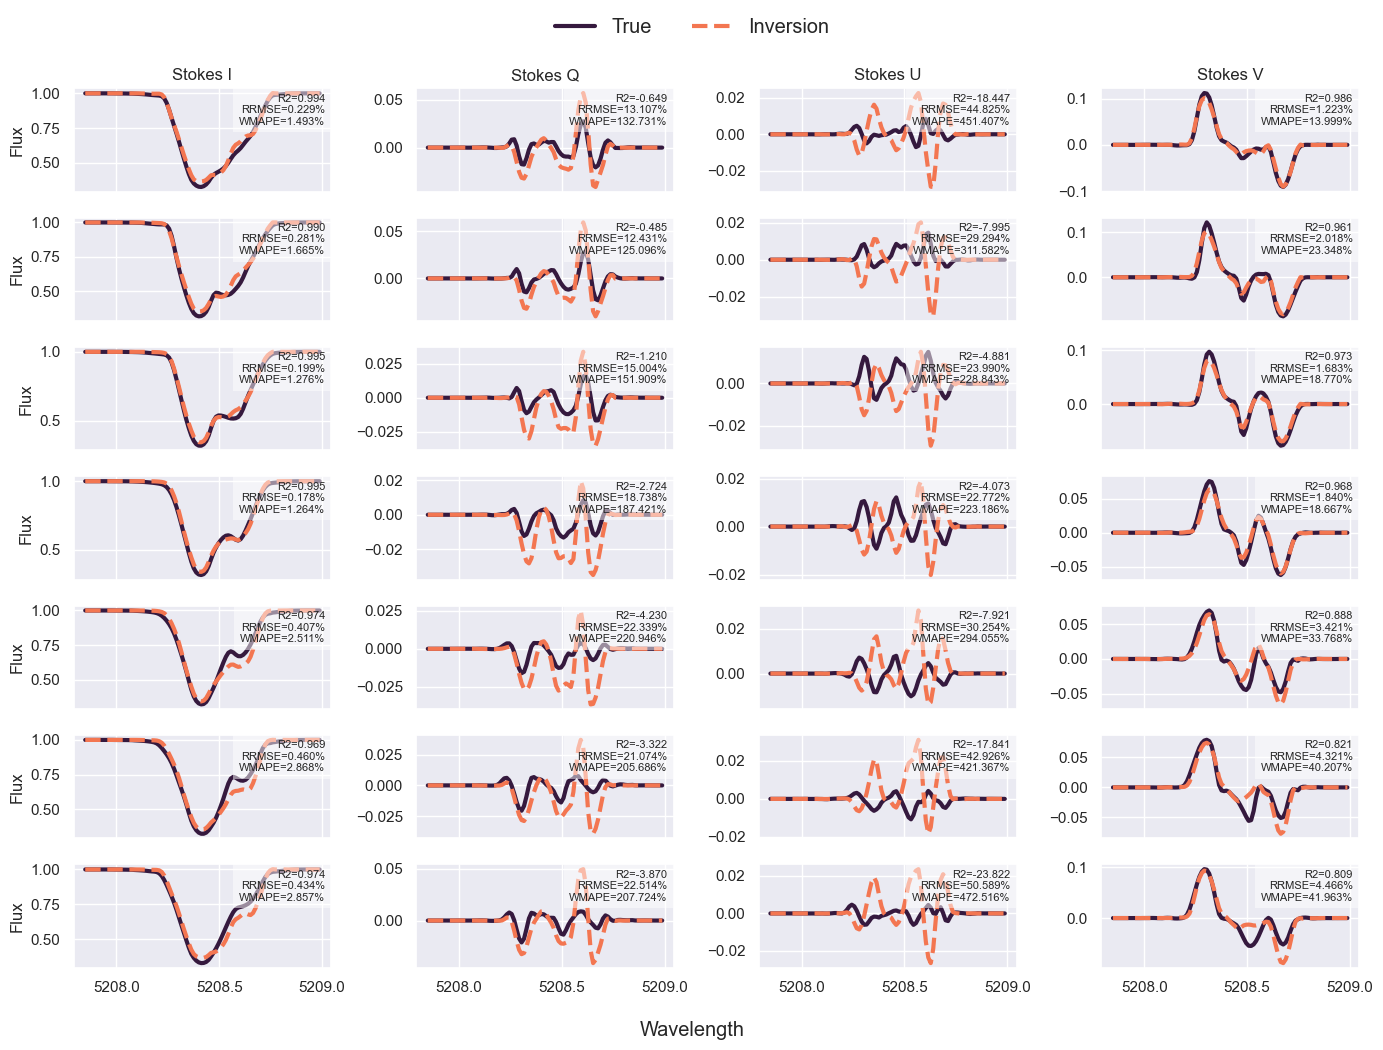

In [24]:
sns.set(rc={"figure.figsize": (14, 10)})
fig, axes = plt.subplots(7, 4, sharex=True)
stokes_labels = ['I', 'Q', 'U', 'V']
wl = net.get_wavelength()
for i in range(7):
    for j in range(4):
        ax = axes[i, j]
        sns.lineplot(x=wl, y=spectrum_phases[i,j,:], lw=3, ax=ax, color=sns.palettes.color_palette('rocket')[0], label='True')
        line_true = ax.lines[-1]
        sns.lineplot(x=wl, y=inv_spectra[i,j,:], lw=3, linestyle='--', ax=ax, color=sns.palettes.color_palette('rocket')[4], label='Inversion')
        line_pred = ax.lines[-1]
        if i == 0:
            ax.set_title(f'Stokes {stokes_labels[j]}')
        ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel('Flux')
            legend_lines = [line_true, line_pred]
        ax.legend().remove()
        ax.text(0.975, 0.95, 
                f'R2={r2_score(spectrum_phases[i,j,:], inv_spectra[i,j,:]):.3f}\nRRMSE={RRMSE(spectrum_phases[i,j,:].reshape(1, 96), inv_spectra[i,j,:].reshape(1, 96))[0]:.3f}%\nWMAPE={weighted_mean_absolute_percentage_error(spectrum_phases[i,j,:], inv_spectra[i,j,:])[0]:.3f}%', 
                transform=ax.transAxes, 
                ha='right', va='top', 
                fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
fig.supxlabel('Wavelength')
fig.legend(legend_lines, ['True', 'Inversion'], loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05), fontsize='large')
plt.tight_layout()
plt.show()

# Make new objective function

In [25]:
def obj(y_true, y_pred):
    err_stokes_i = 0
    err_stokes_q = 0
    err_stokes_u = 0
    err_stokes_v = 0
    for i in range(7):
        start_ph = i*384
        wmape_stokes_i = weighted_mean_absolute_percentage_error(y_true[:,start_ph:start_ph+96], y_pred[:,start_ph:start_ph+96])
        wmape_stokes_q = weighted_mean_absolute_percentage_error(y_true[:,start_ph+96:start_ph+192], y_pred[:,start_ph+96:start_ph+192])
        wmape_stokes_u = weighted_mean_absolute_percentage_error(y_true[:,start_ph+192:start_ph+288], y_pred[:,start_ph+192:start_ph+288])
        wmape_stokes_v = weighted_mean_absolute_percentage_error(y_true[:,start_ph+288:start_ph+384], y_pred[:,start_ph+288:start_ph+384])
        err_stokes_i += wmape_stokes_i/0.096
        err_stokes_q += wmape_stokes_q/8.68
        err_stokes_u += wmape_stokes_u/12.68
        err_stokes_v += wmape_stokes_v/3.63

    return (err_stokes_i+err_stokes_q+err_stokes_u+err_stokes_v)/28

In [30]:
solution, inv_spectra, fitness = net.inversion(spectrum_phases, n_particles=2048, iters=50, verbose=1, phases=phases, objective_function=obj)

----- Start PSO -----
----------------------------
Iteration: 1   Best Fitness: 14.0592785
----------------------------
Iteration: 2   Best Fitness: 11.499034
----------------------------
Iteration: 3   Best Fitness: 8.703153
----------------------------
Iteration: 4   Best Fitness: 8.703153
----------------------------
Iteration: 5   Best Fitness: 5.597726
----------------------------
Iteration: 6   Best Fitness: 5.5128083
----------------------------
Iteration: 7   Best Fitness: 5.208982
----------------------------
Iteration: 8   Best Fitness: 4.0822754
----------------------------
Iteration: 9   Best Fitness: 4.0822754
----------------------------
Iteration: 10   Best Fitness: 3.8932445
----------------------------
Iteration: 11   Best Fitness: 3.770808
----------------------------
Iteration: 12   Best Fitness: 3.3012626
----------------------------
Iteration: 13   Best Fitness: 3.3012626
----------------------------
Iteration: 14   Best Fitness: 3.2360363
-------------------------

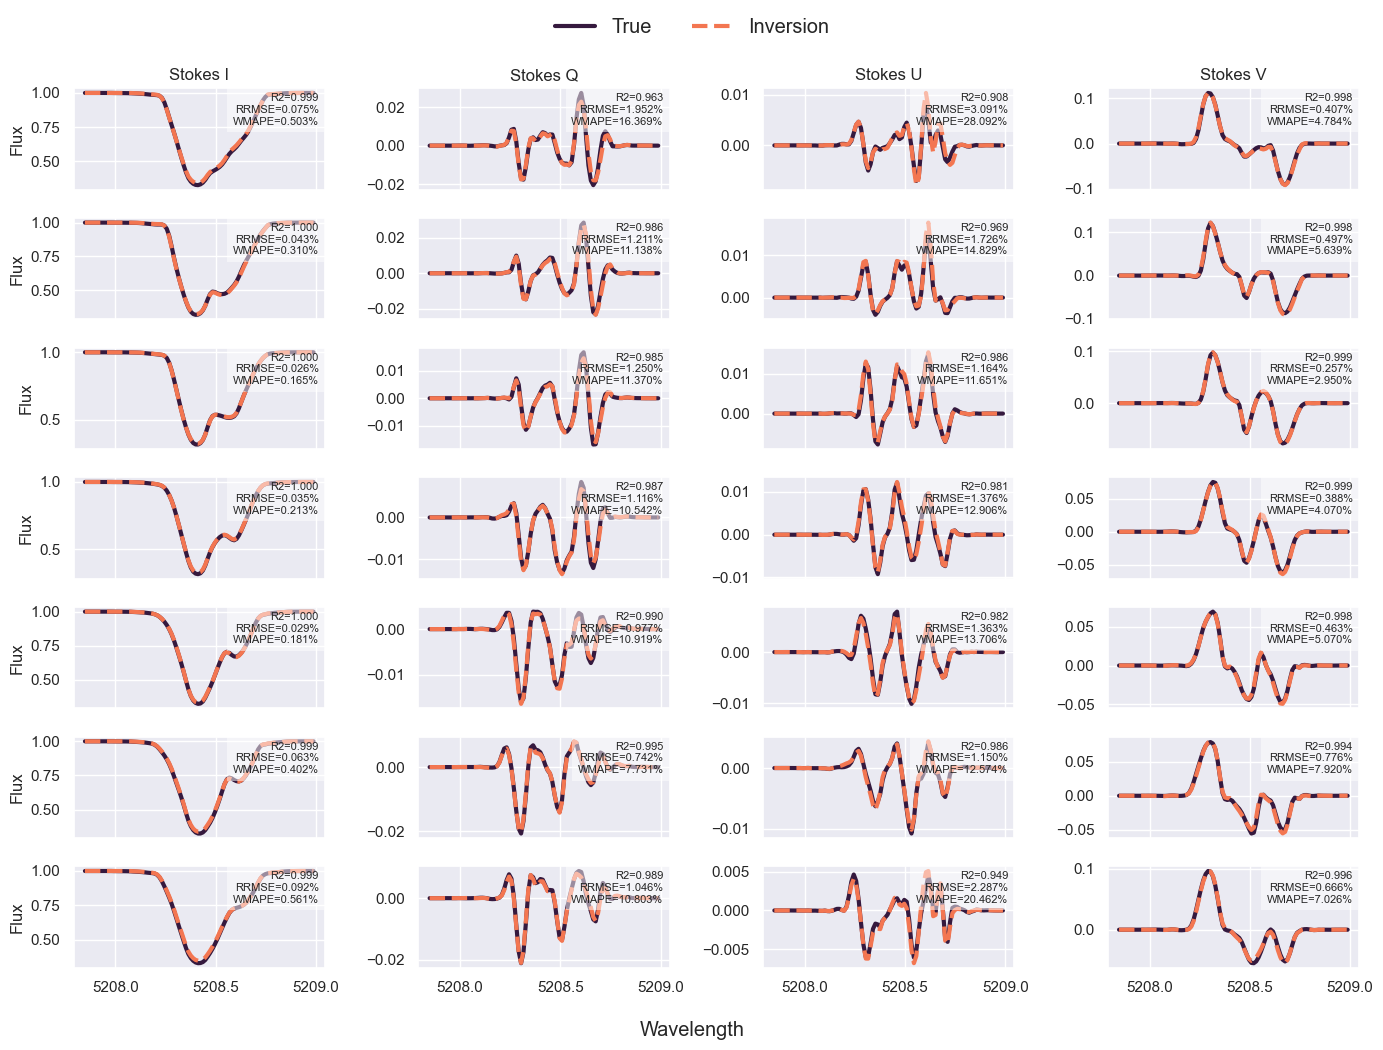

In [31]:
sns.set(rc={"figure.figsize": (14, 10)})
fig, axes = plt.subplots(7, 4, sharex=True)
stokes_labels = ['I', 'Q', 'U', 'V']
wl = net.get_wavelength()
for i in range(7):
    for j in range(4):
        ax = axes[i, j]
        sns.lineplot(x=wl, y=spectrum_phases[i,j,:], lw=3, ax=ax, color=sns.palettes.color_palette('rocket')[0], label='True')
        line_true = ax.lines[-1]
        sns.lineplot(x=wl, y=inv_spectra[i,j,:], lw=3, linestyle='--', ax=ax, color=sns.palettes.color_palette('rocket')[4], label='Inversion')
        line_pred = ax.lines[-1]
        if i == 0:
            ax.set_title(f'Stokes {stokes_labels[j]}')
        ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel('Flux')
            legend_lines = [line_true, line_pred]
        ax.legend().remove()
        ax.text(0.975, 0.95, 
                f'R2={r2_score(spectrum_phases[i,j,:], inv_spectra[i,j,:]):.3f}\nRRMSE={RRMSE(spectrum_phases[i,j,:].reshape(1, 96), inv_spectra[i,j,:].reshape(1, 96))[0]:.3f}%\nWMAPE={weighted_mean_absolute_percentage_error(spectrum_phases[i,j,:], inv_spectra[i,j,:])[0]:.3f}%', 
                transform=ax.transAxes, 
                ha='right', va='top', 
                fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
fig.supxlabel('Wavelength')
fig.legend(legend_lines, ['True', 'Inversion'], loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05), fontsize='large')
plt.tight_layout()
plt.show()